### Voxelize + ANN
Select a threshold density(size), above(below) which we use voxelize, then use ANN to fill in the rest of the cells.

In pseudocode:
```python
high_density_map = voxelize()
full_map = ann(
    data_points = particles,
    query_points = grid_points(Nsize = 512)
    )
```

In [4]:
%load_ext autoreload
%autoreload 2
from vpower.interp import SimulationParticles
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('yjhe.mplstyle')

SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
allPar = SimulationParticles.load_snapshot(SNAPSHOT, remove_bulk_velocity=False)          # load the snapshot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import vpower.voxelize
Nsize = 1024
radii_threshold = 1/512                             # np.min(allPar.h())
smallPar = allPar[allPar.h() <= radii_threshold]
vxzField = smallPar.voxelize_interp_to_field(Nsize=Nsize, edge_removal=True)

Interpolating velocity field...
Padding:  0.0009682633118290873 Lbox:  1.0019365266236582 Nsize:  1024
Auto padding done. Time elapsed: 0.32 s


OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 177131599 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	1.698e+08 exact calculations (R>Rmax),
	7.334e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 177131599 numbers in 5425 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 37.6089 seconds
In the end, 0 in cpu_queue
/appalachia/d6/yujie/Test_PowerSpec/vpower/voxelize.py:108: RuntimeWarning: invalid value encountered in divide
  v_grid = vec_grid[..., :3] / vec_grid[..., 3, None]     # divide by mass


Interpolation done. Time elapsed: 249.06 s


In [5]:
from vpower.interp import deposit_to_grid, make_grid_coords, ann_interpolate, _vec_to_vm_grid, SimulationField3D

eps = 0.1
data_file="data.pts"
query_file="query.pts"
output_file="ann_output.save"

density = vxzField.get_density()
vec_histgrid = np.stack(                        # vec = [vx*rho, vy*rho, vz*rho, rho]
    (                                      
        vxzField.vx * density,       # vectorize as much as possible
        vxzField.vy * density,
        vxzField.vz * density,
        density,
    ),
    axis=3,
)                                               # shape of vec is (Nsize, Nsize, Nsize, 4)

In [ ]:
vec = np.stack(                            # vec = [vx*rho, vy*rho, vz*rho, rho]
    (                                      
        allPar.v[:, 0] * allPar.density,   # vectorize as much as possible
        allPar.v[:, 1] * allPar.density,
        allPar.v[:, 2] * allPar.density,
        allPar.density,
    ),
    axis=1,
)

data_value = vec
print(data_pos.shape, data_value.shape)

query_pos = make_grid_coords(Lbox=vxzField.Lbox, Nsize=Nsize)

vec_grid_ann = ann_interpolate(                # now run ANN to find the nearest neighbor for each query cell
    data_pos=allPar.pos,                     # and link the rho-v vectors to the query cells
    f=data_value,
    Nsize=vxzField.Nsize,
    eps=eps,
    query_pos=None,
    data_file=data_file, # FUTURE: AVOID R/W BY ADDING PYTHON BINDING TO ANN
    query_file=query_file,
    output_file=output_file,
)

(9619086, 3) (9619086, 4)
Data file saved. Time taken: 34.62 s
Query file saved. Time taken: 57.05 s



real	1m18.346s
user	1m16.676s
sys	0m1.447s


Approximate Nearest Neighbour complete. Time taken: 78.39 s.
ANN output read. Time taken: 5.91 s


In [ ]:
# Combination
vec_histgrid = np.nan_to_num(vec_histgrid)      # remove nan
vec_grid_ann[vec_histgrid[..., 3] > 0] = 0
vec_grid = vec_histgrid + vec_grid_ann

In [ ]:
# # Feature: maximize over density. But a crappy hack for now
# boolarr = vec_histgrid[:,:,:,3] > vec_grid_ann[:,:,:,3] 
# boolarr = np.stack((boolarr, boolarr, boolarr, boolarr), 3) # this is ugly
# print(np.shape(boolarr))
# vec_grid = np.where(boolarr, vec_histgrid, vec_grid_ann)    # the voxelize grid will have some nan but it won't affect the result here. But then the sequence matters.

In [ ]:
v_grid, m_grid = _vec_to_vm_grid(vec_grid=vec_grid, Lcell=vxzField.Lcell)  # translate rho-v vectors to velocity and mass fields. or density fields if future required
vxzANNField = SimulationField3D(v_grid, m_grid, Lbox=vxzField.Lbox, Nsize=vxzField.Nsize) # create a SimulationField3D object to store the interpolated field

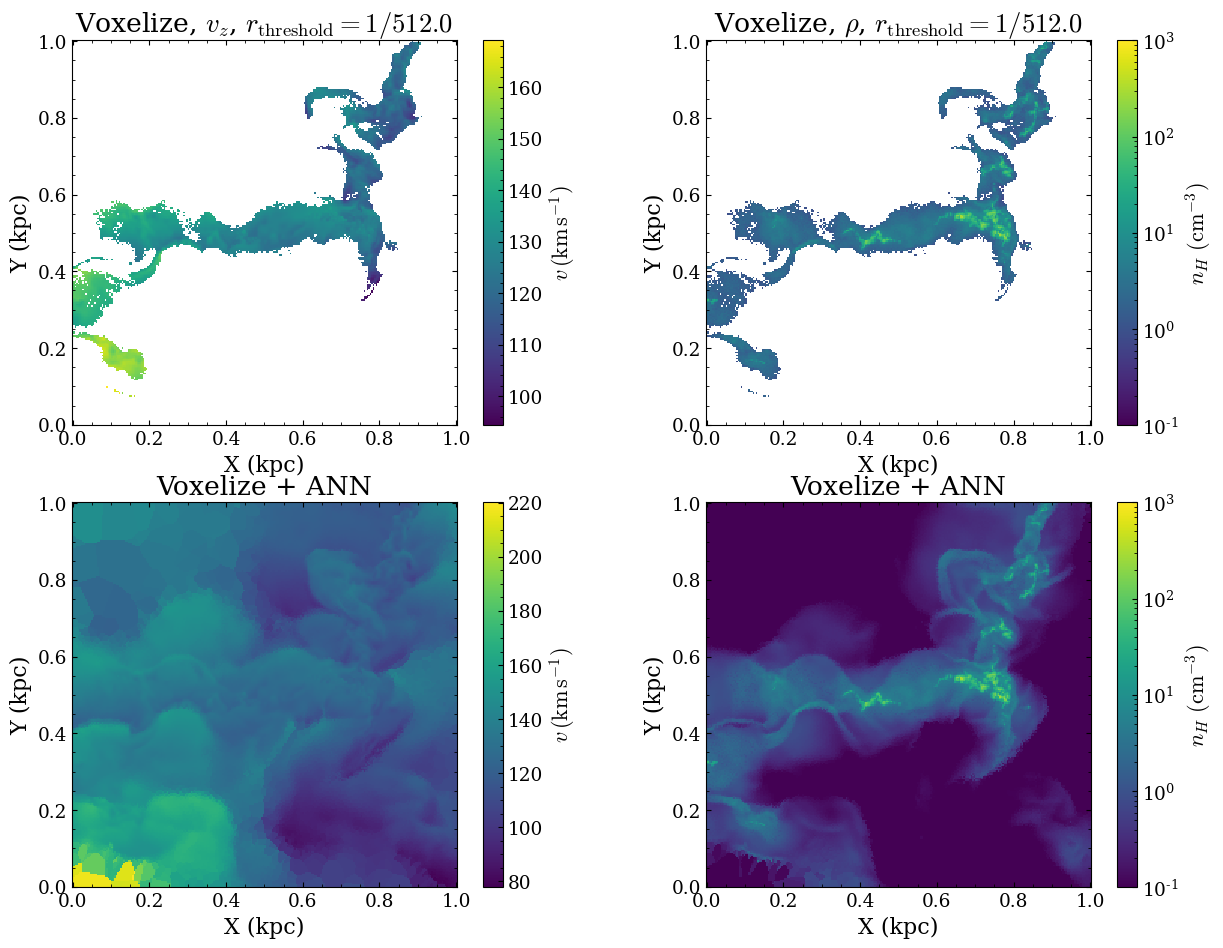

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 11))

vxzField.plot_velocity_slice(component=0, index=vxzField.Nsize//2, axis=2, ax=ax[0,0])
ax[0,0].set_title("Voxelize, $v_z$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))
vxzANNField.plot_velocity_slice(component=0, index=vxzANNField.Nsize//2, axis=2, ax=ax[1,0])
ax[1,0].set_title("Voxelize + ANN")
vxzField.plot_density_slice(index=vxzField.Nsize//2, axis=2, ax=ax[0,1])
ax[0,1].set_title("Voxelize, $\\rho$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))
vxzANNField.plot_density_slice(index=vxzANNField.Nsize//2, axis=2, ax=ax[1,1])
ax[1,1].set_title("Voxelize + ANN")
plt.show()

Test conservation, for different density thresholds and different resolutions. 
- Conserved to what percentage? 
- How does it change with free parameters? 
- How does it change with resolution?

In [ ]:
import vpower as vp
vp.check_conservation(allPar, vxzANNField)

Total mass of particles: 1.260e-03
Total mass after interpolation: 1.241e-03
Total mass restored by 98.484%




Total momentum of particles: [ 0.16640169  0.2250191  -0.00676618]
Total momentum after interpolation: [ 0.16374515  0.22155194 -0.00668435]
Total momentum restored by (98.404%, 98.459%, 98.791%)


Total kinetic energy of particles: 3.141e+01
Total kinetic energy after interpolation: 3.090e+01
Total kinetic energy restored by 98.376%


### Results
##### 70\% filled cells use voxelize, rest use ANN
| Radii threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|------------|---------------|-------------------|-------------------------|
| 1/256 | 256 | 98.484% | (98.404%, 98.459%, 98.791%) | 98.376% |
| 1/512 | 512 | 100.867% | (100.818%, 100.849%, 101.010%) | 100.786% |

##### 100\% filled cells use voxelize, rest use ANN
| Radii threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|------------|---------------|-------------------|-------------------------|
| 1/512 | 256 | 99.861% | (99.748%, 99.830%, 99.835%) | 99.719% |
| 1/512 | 512 | 102.037% | (101.999%, 102.024%, 102.045%) | 101.968% |
##### Combination by 'maximize'
| Radii threshold | Density threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|-------------------|------------|---------------|-------------------|-------------------------|
| 1/512   |         10x       | 256        | 109.099%      | (108.639%, 109.045%, 109.235%) | 108.632%       |
##### Combination by 'stitching'
| Radii threshold | Density threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|-------------------|------------|---------------|-------------------|-------------------------|
| 0.0 (ANN only)   |         10x       | 256        | 98.497%       | (98.429%, 98.457%, 98.103%) | 98.384%       |
| 0.0 (ANN only)   |         10x       | 512        | 98.600%       | (98.551%, 98.574%, 98.895%) | 98.521%       |
| 1/512           |         10x       | 256        | 98.876%       | (98.787%, 98.850%, 99.157%) | 98.758%       |
| 1/512           |         10x       | 512        | 103.780%      | (103.863%, 103.768%, 103.970%) | 103.796%   |
| 1/256           |         10x       | 256        | 100.253%      | (100.291%, 100.189%, 100.700%) | 100.186%   |
| 1/256           |         10x       | 512        | 101.865%      | (101.919%, 101.770%, 102.362%) | 101.779%   |
| 1.0 (Voxelize mostly) |         10x       | 256        | 100.023%      | (100.012%, 100.015%, 99.549%) | 99.998%     |
| 1.0 (Voxelize mostly) |         10x      | 512        | 100.212%      | (100.196%, 100.202%, 99.720%) | 100.187%    |